Ideas:
* Discover ActiveForms, Activations/Inhibitions, or Modifications, a la Mechanism Linker
* Discover indirect relationships (e.g., implied causal transitivity) which may often be missing. Leave the indirect relationships out of training, use for testing?
* Discover direct relationships, perhaps by leaving these out of training?
* Train a model on databases and use to score the a priori likelihood of a triple? May end up penalizing many indirect edges, or relationships that are possibly novel or surprising
* Distant supervision: flag relations as correct or incorrect by whether they are in signor or not (or maybe in any curated database?) and then train a classifier to determine whether the relation is likely correct or not
* Also, could include edges between relations for refinements to estimate the likelihood that having a supports relation implies that the more specific is also true.
* What if KG actually has INDRA statements as nodes, linked to agents (e.g., stmt hassubject agent). Statements could also have properties like MESH terms, refinements, etc. Maybe correct/incorrect? Then could predict relationships between statements. Could test this approach by taking curated statements for training/testing, then 
* Note to self: link prediction is useless if a KG is actually complete/correct (e.g., produced algorithmically). 
* Another note: you also can't expect the prediction process to take into account knowledge that wasn't included in training, e.g., if you train only on DBs, this means you can't use additional evidence about a node from reading to predict other properties of that node. Put another way, the training data represents all available knowledge about the world, for the purposes of link prediction.

https://docs.aws.amazon.com/AmazonECS/latest/developerguide/launch_container_instance.html
https://bcb.github.io/aws/ecs#start-a-container

Questions for Charlie:
* Can EarlyStopper be used on the training loss, i.e., without an evaluator? (Answer I think is to use the training triples for evaluation)
* * Why does this take so long: INFO: [2020-07-11 12:57:52] pykeen.evaluation.evaluator - Starting batch_size search for evaluation now...Can you skip batch size search for the early stopper? (I think yes, by specifying batch size)
* Seeing things flagged as "novel" that are actually in the training set?

To summarize:
* The training loop determines the way of generating training examples. Things that are not in the knowledge graph are deemed to be *wrong*, things in the knowledge graph deemed to be right. Works overall because the "true", completed knowledge graph is still mostly sparse, so most of the things not in the knowledge graph are indeed wrong (look into sLCWA and LCWA).
* The weights in the model are trained to minimize the difference between f(h,r) and f(t), and maximize the difference for f(h,r) and f(t'), where t' is a negative example. There should be a parameter associated with the relative weighting of the positive and negative examples?
* How does the likelihood of an arbitrary triple h,r,t fit in here?



In [50]:
import os
from os.path import join
import json
import pybel
import pykeen
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from pybel import io
from pykeen.models import RotatE
from pykeen.pipeline import pipeline
from pykeen.triples import TriplesFactory
from pykeen.datasets import datasets, Nations, Hetionet, UMLS

from indra.sources import signor
from indra.statements import stmts_from_json
from indra.assemblers.indranet import IndraNetAssembler

In [33]:
save_location = 'kge_data'

def sif_df_to_triples(df):
    # De-duplicate the tuples after collapsing them to simple triples/relations
    raw_tuples = [tuple(t[1:]) for t in df[['agA_name', 'stmt_type', 'agB_name']].itertuples()]
    uniq_tuples = set(raw_tuples)
    triples = np.array(list(uniq_tuples))
    return triples

def sif_df_from_stmts(stmts):
    ina = IndraNetAssembler(stmts)
    stmts_df = ina.make_df()
    stmts_df = stmts_df[~pd.isna(stmts_df.agA_name) & ~pd.isna(stmts_df.agB_name)]
    return stmts_df

In [35]:
source = 'db_sif' # covid19
if source == 'signor':
    sp = signor.process_from_web()
    stmts = sp.statements
    stmt_df = sif_df_from_stmts(stmts)
elif source == 'covid19':
    with open(os.path.join(save_location, 'latest_statements_covid19.json'), 'rt') as f:
        stmt_json = json.load(f)
        stmts = stmts_from_json(stmt_json)
    stmt_df = sif_df_from_stmts(stmts)
elif source == 'db_sif':
    # Load INDRA statement dataframe
    sif_file = join(save_location, 'combined_sif.pkl')
    with open(sif_file, 'rb') as f:
        stmt_df = pickle.load(f)

In [37]:
stmt_df = stmt_df[stmt_df['curated']]
triples = sif_df_to_triples(stmt_df)

In [38]:
triples.shape

(686793, 3)

In [39]:
tf = TriplesFactory(triples=triples)
#training, testing, validation = tf.split([0.95, 0.03, 0.02], random_state=1234)

In [40]:
tf.num_entities, tf.num_relations, tf.num_triples

(24312, 28, 686793)

In [41]:
tf.entity_word_cloud()

In [42]:
tf.relation_word_cloud()

In [43]:
tf.triples[0:5]

array([['SCARNA22', 'Complex', 'POP1'],
       ['2-[3-[[7-[3-[ethyl(2-hydroxyethyl)amino]propoxy]-4-quinazolinyl]amino]-1H-pyrazol-5-yl]-N-(3-fluorophenyl)acetamide',
        'Inhibition', 'KDR'],
       ['PSMD8', 'Complex', 'PUS1'],
       ['LRP5', 'Complex', 'WNT2B'],
       ['NANOS1', 'Complex', 'CNOT1']], dtype='<U257')

In [44]:
# Beyond the pipeline
# Pick a model
from pykeen.models import RotatE
model = RotatE(triples_factory=tf) # would provide loss and regularizer here
model.automatic_memory_optimization = False

# Pick an optimizer from Torch
from torch.optim import Adam
optimizer = Adam(params=model.get_grad_params())

# Pick a training approach (sLCWA or LCWA)
from pykeen.training import SLCWATrainingLoop
training_loop = SLCWATrainingLoop(model=model, optimizer=optimizer)

In [45]:
# Pick an evaluator
from pykeen.evaluation import RankBasedEvaluator
evaluator = RankBasedEvaluator()
evaluator.batch_size = 256

from pykeen.stoppers import EarlyStopper
stopper = EarlyStopper(model, evaluator, tf)

In [46]:
# Train like Cristiano Ronaldo
losses = training_loop.train(num_epochs=2, batch_size=256, continue_training=False)

INFO: [2020-07-16 12:22:14] pykeen.training.training_loop - using stopper: None


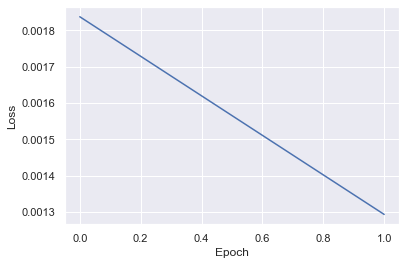

In [47]:
def plot_losses(losses):
    sns.set()
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    return sns.lineplot(x=range(len(losses)), y=losses)
plot_losses(losses)

In [20]:
pred_df = model.predict_tails('MAPK1', 'Phosphorylation')
pred_df

> /Users/johnbachman/Dropbox/1johndata/knowledge file/Biology/Research/Big Mechanism/pykeen/src/pykeen/models/base.py(372)predict_tails()
    371             rv['novel'] = rv['tail_id'].map(lambda tail_id: self._novel(head_id, relation_id, tail_id))
--> 372         if remove_known:
    373             rv = rv[rv['novel']]

ipdb> c


,tail_id,tail_label,score,novel
2954,2954,MAPK1,-1.941377,True
2043,2043,GNAI3,-1.989241,False
2045,2045,GNAO1,-2.012905,False
2041,2041,GNAI1,-2.038778,False
357,357,AKT1,-2.055821,False
...,...,...,...,...
5617,5617,capecitabine,-5.061535,False
5787,5787,lidocaine,-5.101191,False
2311,2311,HOXC4,-5.102166,False
224,224,ABCF1,-5.145137,False


In [27]:
pd.set_option('display.max_rows', 6000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pred_df[~pred_df.novel]

,tail_id,tail_label,score,novel
2043,2043,GNAI3,-1.989241,False
2045,2045,GNAO1,-2.012905,False
2041,2041,GNAI1,-2.038778,False
357,357,AKT1,-2.055821,False
2959,2959,MAPK14,-2.074209,False
2046,2046,GNAQ,-2.092096,False
356,356,AKT,-2.097732,False
971,971,CDK1,-2.103984,False
4788,4788,SRC,-2.117224,False
4052,4052,PRKCA,-2.132533,False


In [ ]:
use_cached = False
save_location = 'kge_data'
if not use_cached:
    result.save_to_directory(save_location)
    model = result.model
    #print(*[x for x in dir(result) if not x.startswith('_')], sep='\n')
else:
    model_file = os.path.join(save_location, 'trained_model.pkl')
    #with open(model_file, 'rb') as f:
    #    model = pickle.load(f)
os.listdir(save_location)


In [ ]:
result.metric_results.to_df()

# Extra Snippets

In [ ]:
# Pick an evaluator
from pykeen.evaluation import RankBasedEvaluator
evaluator = RankBasedEvaluator(model)

# Get triples to test
mapped_triples = dataset.testing.mapped_triples

# Evaluate
results = evaluator.evaluate(mapped_triples, batch_size=1024)
print(results)

In [ ]:
result = pipeline(
    training_triples_factory=training,
    testing_triples_factory=testing,
    #validation_triples_factory=validation,
    model = 'RotatE',
    training_kwargs=dict(num_epochs=5),
    random_seed=1235,
    training_loop='sLCWA', # vs LCWA
    negative_sampler='basic', # Don't use this arg if using LCWA
    #negative_sampler=BasicNegativeSampler, # see pykeen.sampling
    device='cpu',
    #evaluator= RankBasedEvaluator, # see pykeen.evaluation
    #stopper='early',
    #model_kwargs # parameters for model's __init__ method
)

In [ ]:
result.plot_losses()
plt.show()

In [ ]:
"""
from pykeen.hpo import hpo_pipeline
hpo_pipeline(
    model='RotatE',
    dataset='Nations',
    model_kwargs_ranges=dict(
        embedding_dim=dict(low=50, high=200, q=50),
    ),
    loss='NSSA',
    loss_kwargs_ranges=dict(
        margin=dict(type='categorical', value=[1, 2]),
    ),
    sampler='TPE',
)
"""

In [ ]:
"""
# Method of getting an EMMAA model via PyBEL
ras_triples_path = 'ras_machine_triples.csv'
import pybel
print(pybel.get_version(with_git_hash=True))
graph = pybel.from_emmaa('rasmachine')
graph.summarize()
triples = pybel.io.tsv.api.get_triples(graph)
triples = np.array(list(map(list, triples)))
np.savetxt(ras_triples_path, triples, fmt='%s', delimiter='\t')
"""

In [ ]:
"""
result = pipeline(
    dataset='Nations',
    model='RotatE',
    model_kwargs=dict(embedding_dim=50),
    loss='NSSA',
    loss_kwargs=dict(margin=1.0, adversarial_temperature=1.0),
    training_kwargs=dict(num_epochs=100)
)

result = pipeline(
    dataset=dataset,
    model='RotatE',
    model_kwargs=dict(embedding_dim=50),
    loss='NSSA',
    loss_kwargs=dict(margin=1.0, adversarial_temperature=1.0),
    training_kwargs=dict(num_epochs=100)
)
"""